In [1]:
import torch
import random
from pathlib import Path
from miditok import REMI, TokenizerConfig

from src.model.model import MusicTransformer
from src.utils.hyperparameters import (
    BLOCK_SIZE, EMBEDDING_DIM, N_LAYER, N_HEAD, DROPOUT, VOCAB_SIZE
)
from src.utils.data.random_guitar_seq_dataset import RandomGuitarSeqDataset

/home/piffs/dev/miniconda3/envs/music-llm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps') # metal for Apple Silicon
else:
    device = torch.device('cpu')

print("Using device:", device)

Using device: cuda


In [3]:
data_root = Path("../data")
tokenized_folder = data_root / "tokenized/"
val_tok_folder = tokenized_folder / "val/"

In [4]:
# Prepare the validation dataset loader again, to pick out test input samples
val_files = sorted(val_tok_folder.glob("*.json"))

val_ds = RandomGuitarSeqDataset(block_size=BLOCK_SIZE, epoch_len=400, file_list=val_files)

In [5]:
# Load checkpoints from disk and reset hyperparams
ckpt = torch.load("../data/checkpoints/best.pt", map_location=device)
vocab_size = ckpt.get("vocab_size", VOCAB_SIZE)
h = ckpt.get("hyperparams", {})
n_embd = h.get("n_embd", EMBEDDING_DIM)
n_head = h.get("n_head", N_HEAD)
n_layer = h.get("n_layer", N_LAYER)
block_size = h.get("block_size", BLOCK_SIZE)
dropout = h.get("dropout", DROPOUT)

In [6]:
model = MusicTransformer(
    vocab_size=vocab_size,
    n_embd=n_embd,
    n_head=n_head,
    n_layer=n_layer,
    block_size=block_size,
    dropout=dropout
).to(device)

In [7]:
model.load_state_dict(ckpt["model"])
model.eval()
print("Loaded checkpoint from epoch", ckpt["epoch"])

Loaded checkpoint from epoch 29


ModuleList(
  (0-3): 4 x RelativeHead(
    (query): Linear(in_features=384, out_features=96, bias=False)
    (key): Linear(in_features=384, out_features=96, bias=False)
    (value): Linear(in_features=384, out_features=96, bias=False)
    (rel_bias): Embedding(512, 96)
    (dropout): Dropout(p=0.2, inplace=False)
  )
)


ValueError: x and y must have same first dimension, but have shapes (1023,) and (512, 96)

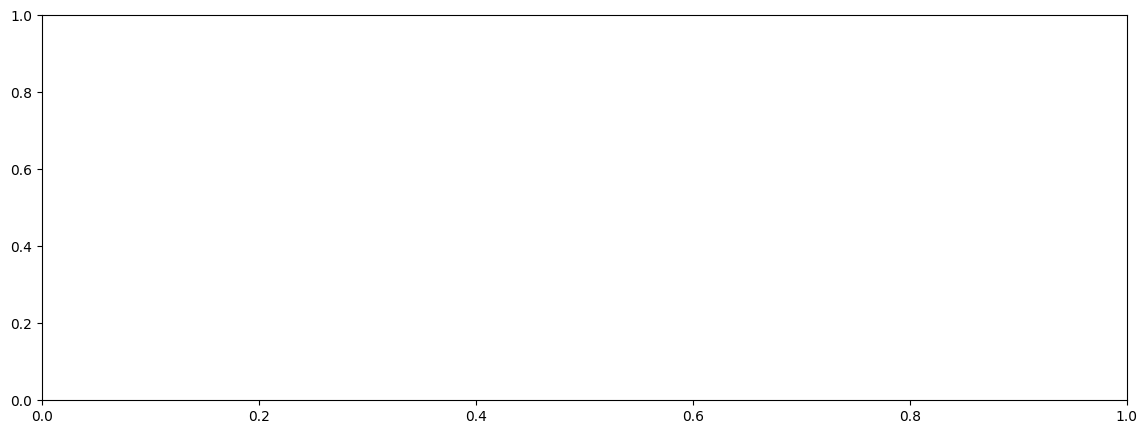

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Extract bias weights from one head (example)
heads = model.blocks[0].mmha.heads
print(heads)
rel_bias = heads[0].rel_bias.weight
bias = rel_bias.detach().cpu().squeeze(-1).numpy()

T = model.block_size
distances = np.arange(-T+1, T)

plt.figure(figsize=(14, 5))
plt.plot(distances, bias)
plt.axhline(0, color='black', linewidth=0.5)
plt.title("Learned Relative Attention Bias (distance → bias)")
plt.xlabel("Relative Distance (j - i)")
plt.ylabel("Bias")
plt.grid(True)
plt.show()


In [12]:
# item = random.randrange(len(val_ds))
item = 1623
x, y = val_ds[item]
x = x.unsqueeze(0).to(device)
y = y.to(device)
temp = x[:500]
out = model.generate(temp.view(1, -1).to(device), max_new_tokens=2500).cpu()
out

tensor([[ 679,  507, 1110,  ...,  450, 2358,  831]])

In [13]:
tokenizer = REMI(params=Path("../data/tokenized/config/tokenizer.json"))
print("Is trained", tokenizer.is_trained)
out_midi = tokenizer.decode(out[0])
# temp_midi = tokenizer.decode(temp)

Is trained True


/home/piffs/dev/miniconda3/envs/music-llm/lib/python3.12/site-packages/miditok/tokenizations/remi.py:88: UserWarning: Attribute controls are not compatible with 'config.one_token_stream_for_programs' and multi-vocabulary tokenizers. Disabling them from the config.
  super().__init__(tokenizer_config, params)


In [14]:
out_midi.dump_midi(data_root / "output" / f"{item}_test_gen_2.mid")
# temp_midi.dump_midi(data_root / "output" / f"{item}_input_input_2.mid")
print(f"{item}_test_gen_2.mid")

1623_test_gen_2.mid
